*** The model proposed will have the constraints discussed in today's meeting. Afterwards I will put the explicit mathematical explanation of the Hamiltonian. ***

In [1]:
import math as mt 
import numpy as np 
import matplotlib.pyplot as plt 
import random as rd 
from collections import defaultdict
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite 
import numpy as np 
import dimod 
from dwave.embedding.chain_strength import uniform_torque_compensation
from dwave.embedding.chain_strength import scaled
from dwave.embedding.chain_breaks import majority_vote
from dwave.embedding.chain_breaks import discard
from dwave.system import LeapHybridCQMSampler
import neal 
from scipy.optimize import minimize
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit import Aer,execute


rd.seed(30031935)

In [2]:
def FacilityLocation(n_atms,n_clients,radio_clients,radio_atms,solver,lambda1,lambda2,p=1):
    
    rd.seed(30031935)
    np.random.seed(30031935)
    
    assert solver in ('ExactSolver', 'SimulatedAnnealing', 'DWaveSampler', 'CQM', 'QAOA') , 'Introduce a valid Solver'
    

    atms_lat = [] ; atms_lon = [] ; atms_loc = []
    clients_lat = [] ; clients_lon = [] ; clients_loc = []
    e = [] 

    for i in range(n_atms): # We assign random positions to our ATMs

        lat = rd.uniform(0.001,0.999) ; lon = rd.uniform(0.001,0.699) 
        atms_lat.append(lat) ; atms_lon.append(lon) ; atms_loc.append((lon,lat))


    for i in range(n_clients): # We assign random positions to our clients

        lat=rd.uniform(0.001,0.999) ; lon=rd.uniform(0.001,0.699) 
        clients_lat.append(lat) ; clients_lon.append(lon) ; clients_loc.append((lon,lat))
        
    # We assign profit to our clients from a normal distribution (sigma = 5000, u = 10 000)
                                    #take abs() of it to avoid negative pofits
        profits = np.random.normal(10000, 5000, n_clients)
        profits = np.abs(profits)
        profits_normalized = profits/10000 # these are normalized, to use for our optimization
        
    
    values_customers = [0.2,0.4,0.6,0.8,1.0] # Each customer will be assgined to one category in based on its value 
    

    #for j in range(n_clients): # We assign a category. ( the higher the number, the better the quality of the customer)

     #   e.append(rd.choice(values_customers))
        


    ##################################################################################
    ##################################################################################
    # We create a dictionary (the QUBO matrix). The terms on the diagonal will be the linear terms, and the terms outside of it
    # will be the quadratic terms of out Hamiltonian. Each constraint will have a value associated (lambda) which indicates its strength
    
    Q = defaultdict(int)

    lambda1 = 1
    lambda2 = 100
    
    
    ###################### Constraint 1 #########################
    
    
    def EuclideanDistance(x,y): ## We define a function to compute the euclidean distance 
    
        return (np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2))

    distances_clients_atms = [] 

    for i in range(n_atms):
    
        suma = 0
        minim =0
    
        for j in range(n_clients):
            
            distances_clients_atms.append(EuclideanDistance(atms_loc[i],clients_loc[j]))
            
            if EuclideanDistance(atms_loc[i],clients_loc[j]) <= radio_clients : # We consider circles of radius radio_clients
        
                suma += (1/EuclideanDistance(atms_loc[i],clients_loc[j])) * profits_normalized[j]
                suma += (-EuclideanDistance(atms_loc[i],clients_loc[j])) * profits_normalized[j]
                if suma < minim:
                    minim = suma

    
                Q[(i,i)] -= lambda1 * suma - minim # We append the term to our QUBO matrix 
        
    ############### Constraint 3 ##############################
    
    #### We assign a cluster to each of the ATMs 

    distances_atms_atms = []
    
    for i in range(n_atms-1):
        
        for j in range(i+1,n_atms):
            
            distances_atms_atms.append(EuclideanDistance(atms_loc[i],atms_loc[j]))
            
            if EuclideanDistance(atms_loc[i],atms_loc[j]) <= radio_atms: # we add coupling terms to points that are closer than that distance
                
                #Q[(i,j)] += lambda2 * (1/EuclideanDistance(atms_loc[i],atms_loc[j]))
                Q[(i,j)] += lambda2 *(np.sqrt(Q[i,i]*Q[j,j]))
            
    
                    
######################################################################################
######################################################################################
######## We define a function to plot the results ####################################



    def plots(atms_lon,atms_lat,clients_lon,clients_lat,sol_min):
        vx = 15*5
        vy = 20*5

        ys = np.linspace(0,1.0,vx)
        xs = np.linspace(0,0.7,vy)


        def aligntogrid(x_data, y_data, xs, ys):


            #shifts the data to the nearest grid point
            x_new_data = []
            y_new_data = []
            for x in x_data:


                absolute_difference_function = lambda list_value : abs(list_value - x)

                closest_value = min(xs, key=absolute_difference_function)
                x_new_data.append(closest_value)

            for y in y_data:

                absolute_difference_function = lambda list_value : abs(list_value - y)

                closest_value = min(ys, key=absolute_difference_function)
                y_new_data.append(closest_value)

            return x_new_data, y_new_data    





        longitudes_atm, latitudes_atm = aligntogrid(atms_lon, atms_lat, xs, ys)
        longitudes_clients , latitudes_clients = aligntogrid(clients_lon,clients_lat,xs,ys)

        fig = plt.axes()
        fig.figure.set_size_inches(12,12)
        major_ticks_top=np.linspace(0,0.7,(vx))
        fig.set_xticks (major_ticks_top, minor = True)
        major_ticks_top=np.linspace(0, 1.0, (vy))
        fig.set_yticks(major_ticks_top, minor = True)
        fig.grid(which = 'minor')
        fig.plot(longitudes_atm, latitudes_atm, 'ro')
        fig.plot(longitudes_clients,latitudes_clients,'bx')

        longitudes_open_atm = []
        latitudes_open_atm = []

        for i in range(len(sol_min)):

            if sol_min[i] == 1:

                longitudes_open_atm.append(longitudes_atm[i])
                latitudes_open_atm.append(latitudes_atm[i])


        fig.plot(longitudes_open_atm,latitudes_open_atm,'gs',markersize = 10)

        plt.show()
    
    ##################################################################################
    ##################################################################################
    
    ### We will solve the problem using different samplers 
    
    if solver == 'ExactSolver':
    
        sampler = dimod.ExactSolver()
        sol = sampler.sample_qubo(Q)
        
        sol_array = list(sol.record.field(0))
        energy = list(sol.record.field(1))
    
        sol_min = sol_array[energy.index(min(energy))]
        e_min = min(energy)
        
        
        #plots(atms_lon,atms_lat,clients_lon,clients_lat,sol_min)
        return(distances_clients_atms,distances_atms_atms,e,sol_min,e_min, atms_lon, atms_lat, clients_lon, clients_lat, profits)
        
        
    if solver == 'SimulatedAnnealing':
        
        sampler = neal.SimulatedAnnealingSampler()
        sol = sampler.sample_qubo(Q)
        
        sol_array = list(sol.record.field(0))
        energy = list(sol.record.field(1))
    
        sol_min = sol_array[energy.index(min(energy))]
        e_min = min(energy)
        
        
        plots(atms_lon,atms_lat,clients_lon,clients_lat,sol_min)
        return(distances_clients_atms,distances_atms_atms,e,sol_min,e_min, atms_lon, atms_lat, clients_lon, clients_lat, profits)        
    
             
    if solver == 'DWaveSampler': 
        
        sol_min_list = []
        e_min_list = [] 

        
        for t in range(50): ### We run the annealer 10 times and take the best result
            
            print(t)
        
            sampler = EmbeddingComposite()
            sol = sampler.sample_qubo(Q,chain_break_method = majority_vote,chain_strength = 2)

            sol_array = list(sol.record.field(0))
            energy = list(sol.record.field(1))

            sol_min_temp = sol_array[energy.index(min(energy))]
            e_min_temp = min(energy)
            
            sol_min_list.append(sol_min_temp)
            e_min_list.append(e_min_temp)
            
        sol_min = sol_min_list[e_min_list.index(min(e_min_list))]
        e_min = min(e_min_list)
        
        plots(atms_lon,atms_lat,clients_lon,clients_lat,sol_min)
        return(distances_clients_atms,distances_atms_atms,e,sol_min,e_min , atms_lon, atms_lat, clients_lon, clients_lat, profits)
        
        
    if solver == 'CQM': 
        
        
        cqm = dimod.ConstrainedQuadraticModel()
        z = [dimod.Binary(f'z_{i}') for i in range(n_atms)]
        cqm.set_objective(sum(Q[(i,i)]*z[i] for i in range(n_atms))+
                          +sum(((Q[(i,j)]*z[i]*z[j] for i in range(n_atms-1))for j in range(i+1,n_atms))))
        
    
        
        
        cqm_sampler = LeapHybridCQMSampler()
        sol = cqm_sampler.sample_cqm(cqm)
        feasible_sampleset = sol.filter(lambda row: row.is_feasible)
        sol_array = list(feasible_sampleset.record.field(0))
        energy = list(feasible_sampleset.record.field(1))
    
        sol_min = sol_array[energy.index(min(energy))]
        e_min = min(energy)
        
        plots(atms_lon,atms_lat,clients_lon,clients_lat,sol_min)
        return(distances_clients_atms,distances_atms_atms,e,sol_min,e_min, atms_lon, atms_lat, clients_lon, clients_lat, profits)
            
    if solver == 'QAOA' : 
          
        def circuit(Q,parameters,n): 
            
            qc = QuantumCircuit(n)

            beta = parameters[:p]
            gamma = parameters[p:]

            for i in range(n):

                qc.h(i)

            for j in range(p):

                for e in Q.keys():

                    if e[0] != e[1]:

                        qc.rzz(Q[e]*gamma[j],e[0],e[1])

                    if e[0] == e[1]:

                        qc.rz(Q[e]*gamma[j],e[0])

                for i in range(n):

                    qc.rx(beta[j],i)

            qc.measure_all()

            return(qc)
        
        def minimizer(Q,p): 

            def expectation(parameters,Q=Q,p=p):

                n = 0 

                parameters = np.random.rand (2*p)

                for k in Q.keys():

                    if k[0] == k[1]:

                        n += 1

                
                qc = circuit(Q,parameters,n)

                sim = Aer.get_backend('aer_simulator')
                counts=sim.run(qc,seed_simulator=100,nshots=1024).result().get_counts()

                Q_array = np.empty((n,n),dtype = np.float64)

                for i in range(n-1):

                    Q_array[i,i] = Q[(i,i)]

                    for j in range(i+1,n):

                        Q_array[(i,j)] = Q[(i,j)]

                Q_array[n-1,n-1] = Q[(n-1,n-1)]


                Etot= 0

                for k in counts.keys():

                    sample = np.empty((n,1),dtype = np.float64)




                    for i in range(len(k)):

                        sample[i,0] = (int(k[i]))


                    E= np.matmul(np.transpose(sample),np.matmul(Q_array,sample))
                    #print(E)


                    if counts[k] >1e-05:

                        Etot += (E*counts[k])/1024 

                    k_max_list = []

                    for k in counts.keys(): 

                        if counts[k] == max(counts.values()):

                            k_max = k

                    for i in k_max: 

                        k_max_list.append(int(i))



                    return(Etot)
            
            init_params = 0.01 * np.random.rand(2*p)
            
            return(minimize(expectation,init_params,method='Powell'))

            
        params = minimizer(Q,p)['x'][0]
        print(params)
        
        n = 0 


        for k in Q.keys():

            if k[0] == k[1]:

                n += 1

        qc = circuit(Q,params,n)
        
        

        sim = Aer.get_backend('aer_simulator')
        counts=sim.run(qc,seed_simulator=100,nshots=1024).result().get_counts()

        Q_array = np.empty((n,n),dtype = np.float64)

        for i in range(n-1):

            Q_array[i,i] = Q[(i,i)]

            for j in range(i+1,n):

                Q_array[(i,j)] = Q[(i,j)]

        Q_array[n-1,n-1] = Q[(n-1,n-1)]


        Etot= 0

        for k in counts.keys():

            sample = np.empty((n,1),dtype = np.float64)




        for i in range(len(k)):

            sample[i,0] = (int(k[i]))


        E= np.matmul(np.transpose(sample),np.matmul(Q_array,sample))
        #print(E)


        if counts[k] >1e-05:

            Etot += (E*counts[k])/1024 

        k_max_list = []

        for k in counts.keys(): 

            if counts[k] == max(counts.values()):

                k_max = k

        for i in k_max: 

            k_max_list.append(int(i))


        plots(atms_lon,atms_lat,clients_lon,clients_lat,k_max_list)
        return (distances_clients_atms,distances_atms_atms,e,Etot,k_max_list, atms_lon, atms_lat, clients_lon, clients_lat, profits)
    

In [3]:
a = FacilityLocation(19,1000,0.20,0.7,'ExactSolver',1,5)
print(len(a))

atms_lon = np.array(a[5])
atms_lat = np.array(a[6])
clients_lon = np.array(a[7])
clients_lat = np.array(a[8])
profits = np.array(a[9])

10


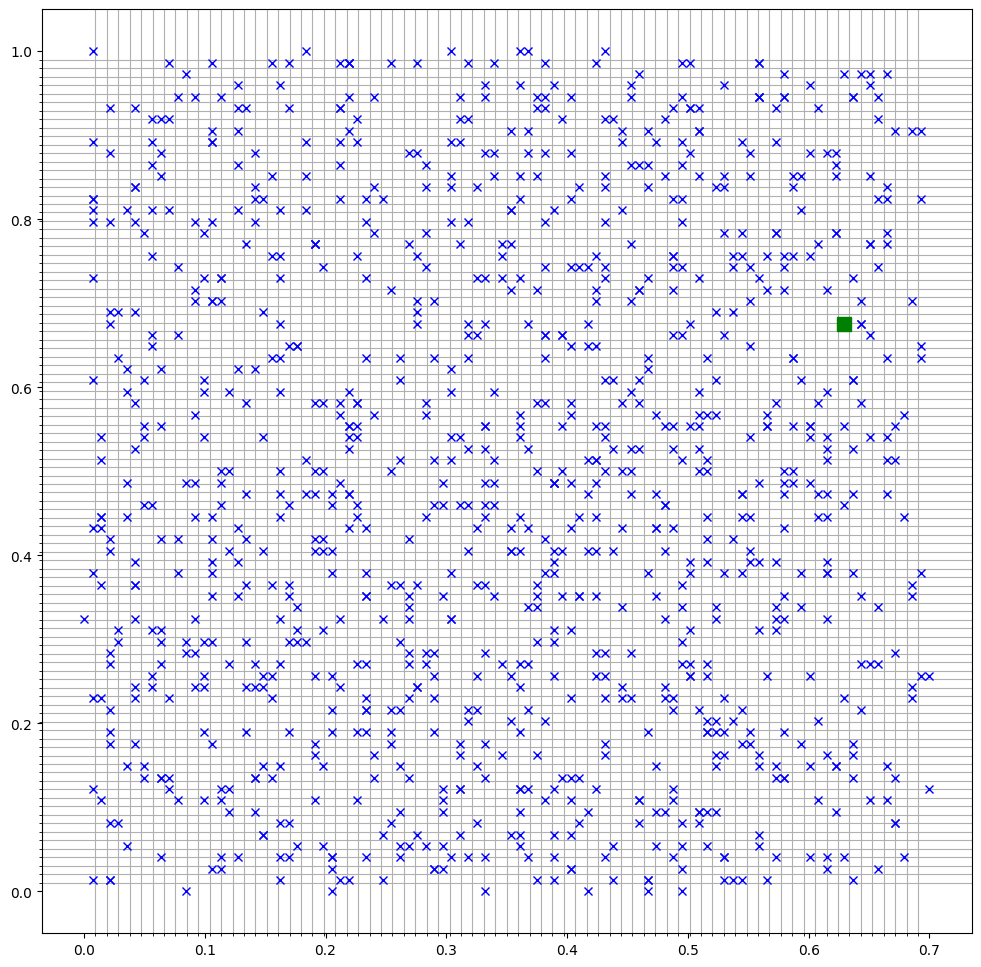

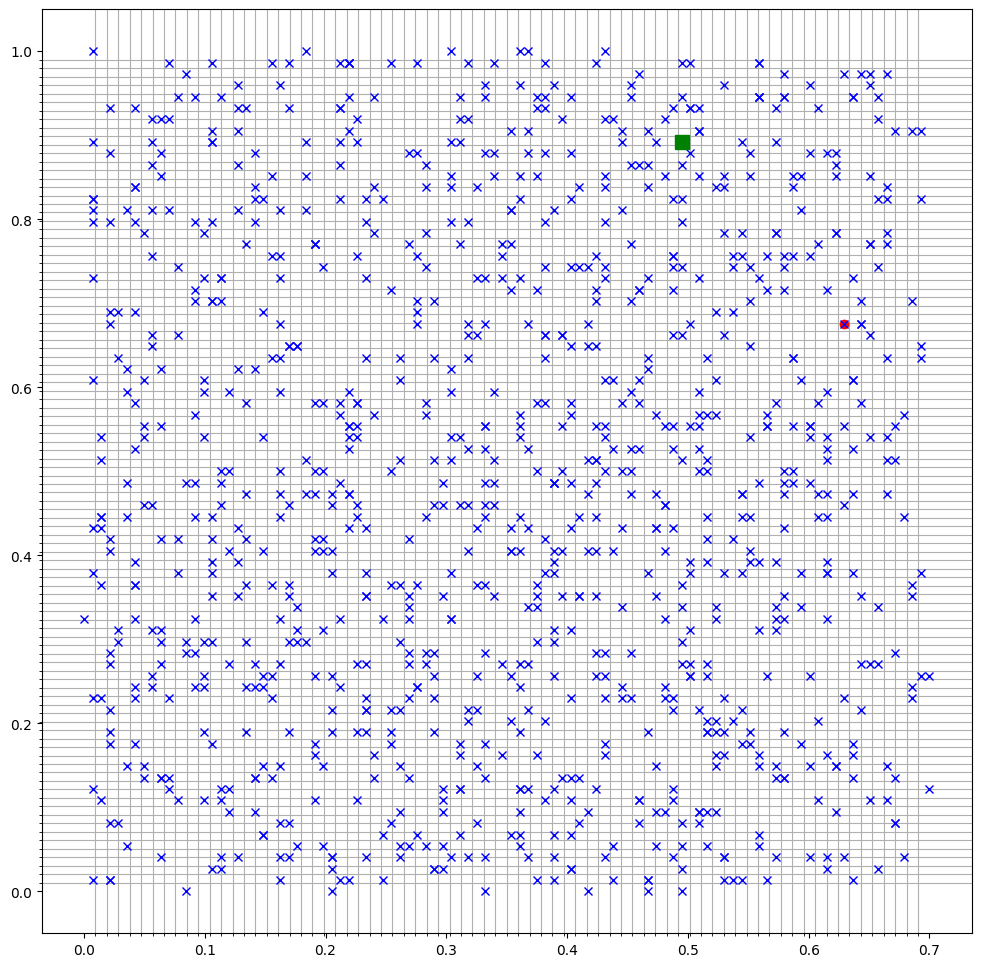

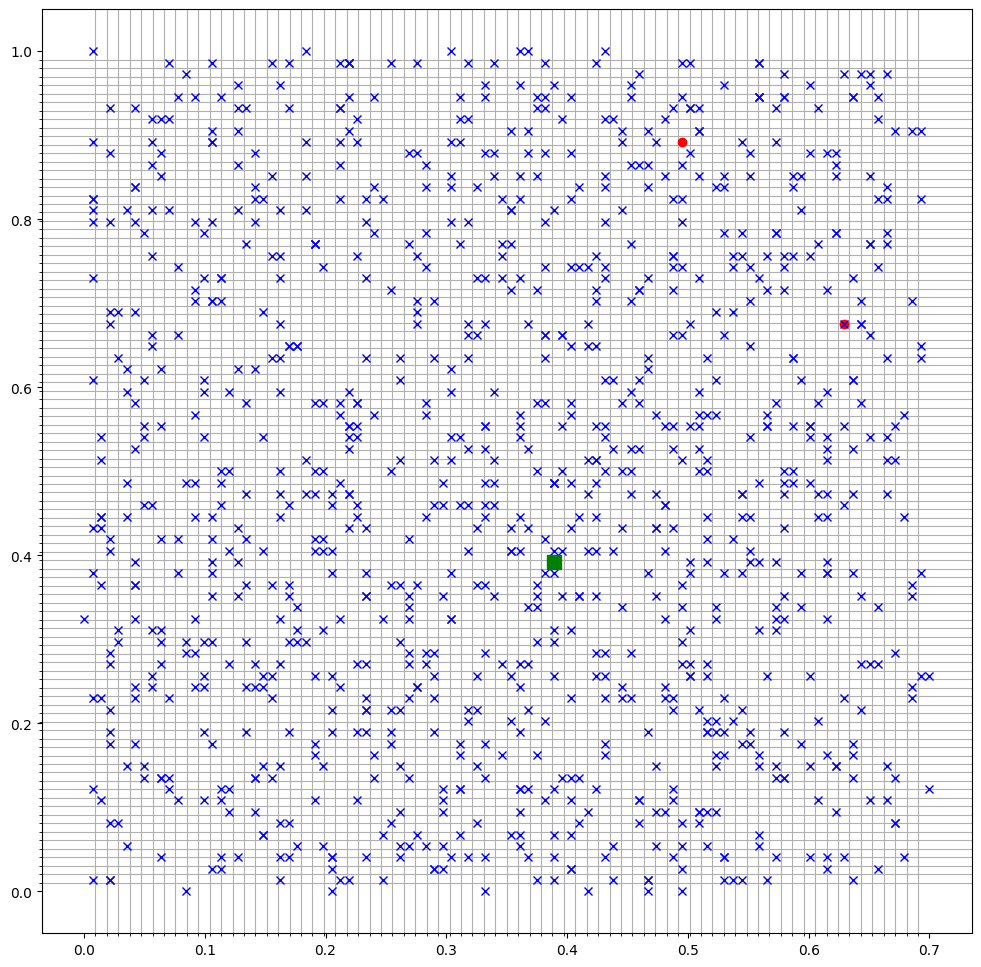

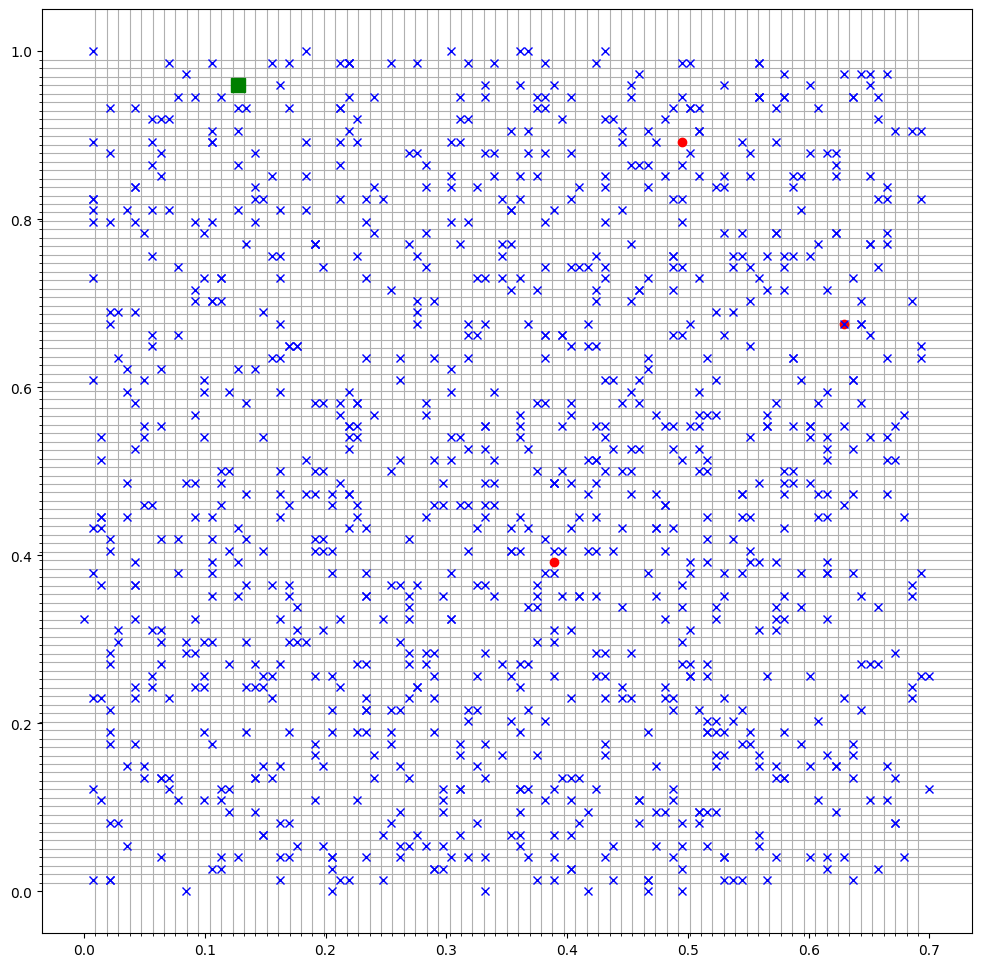

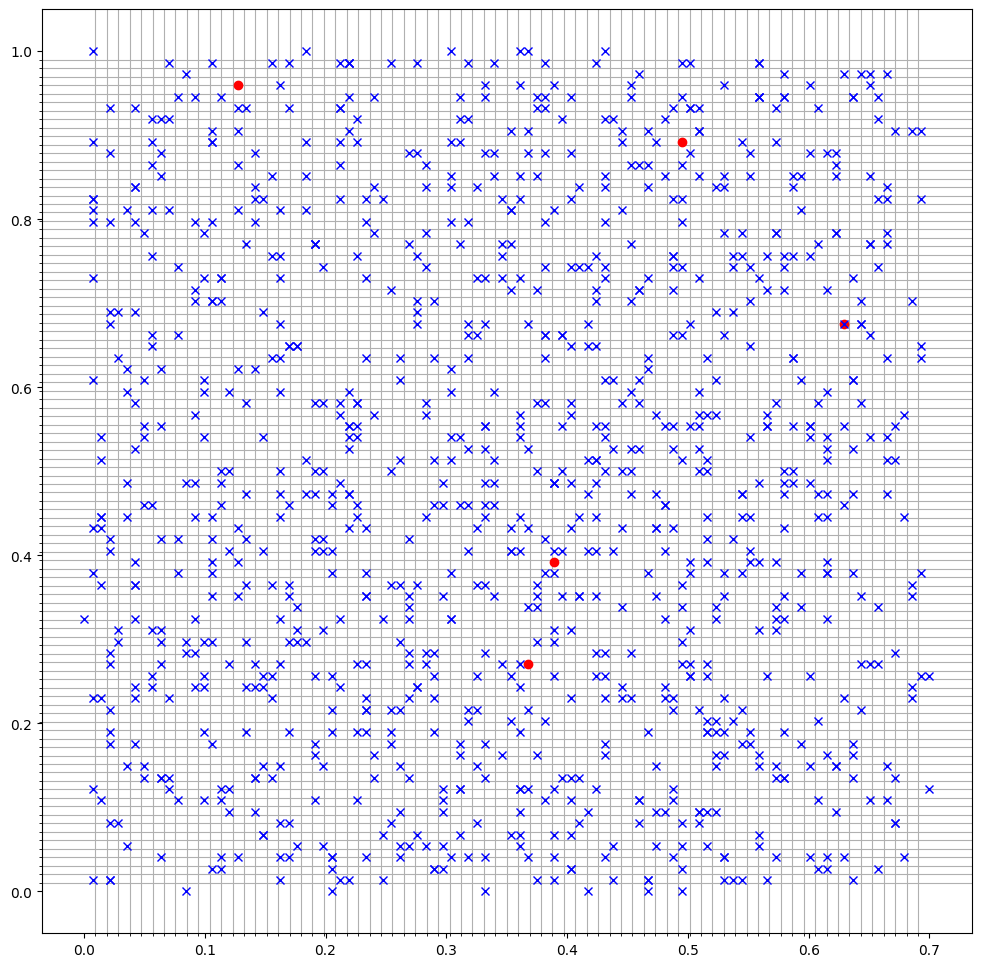

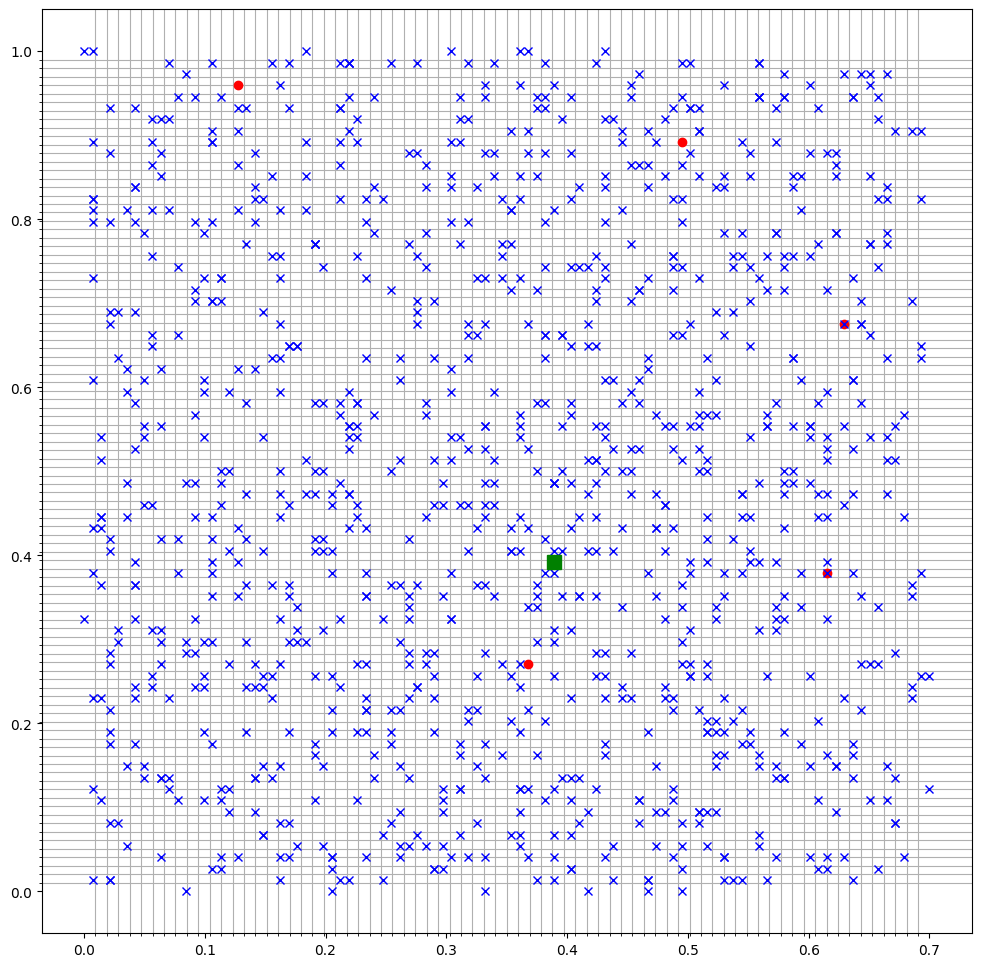

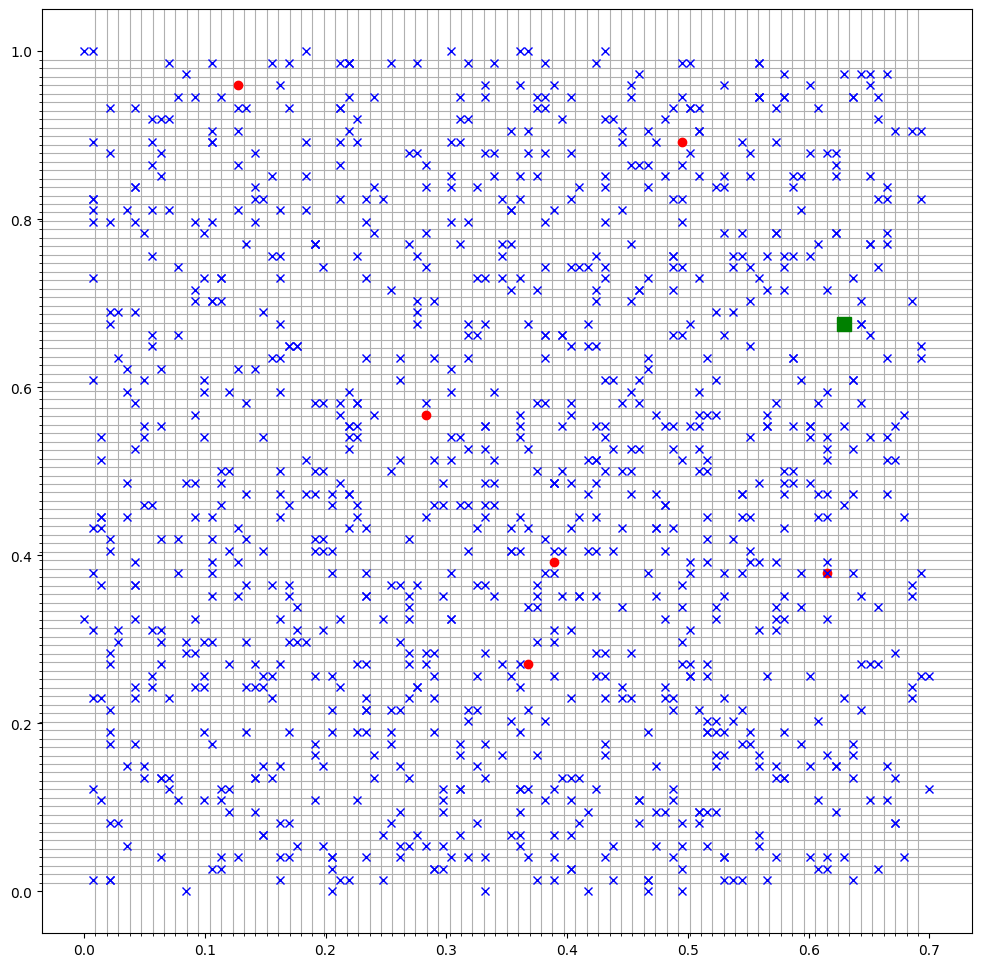

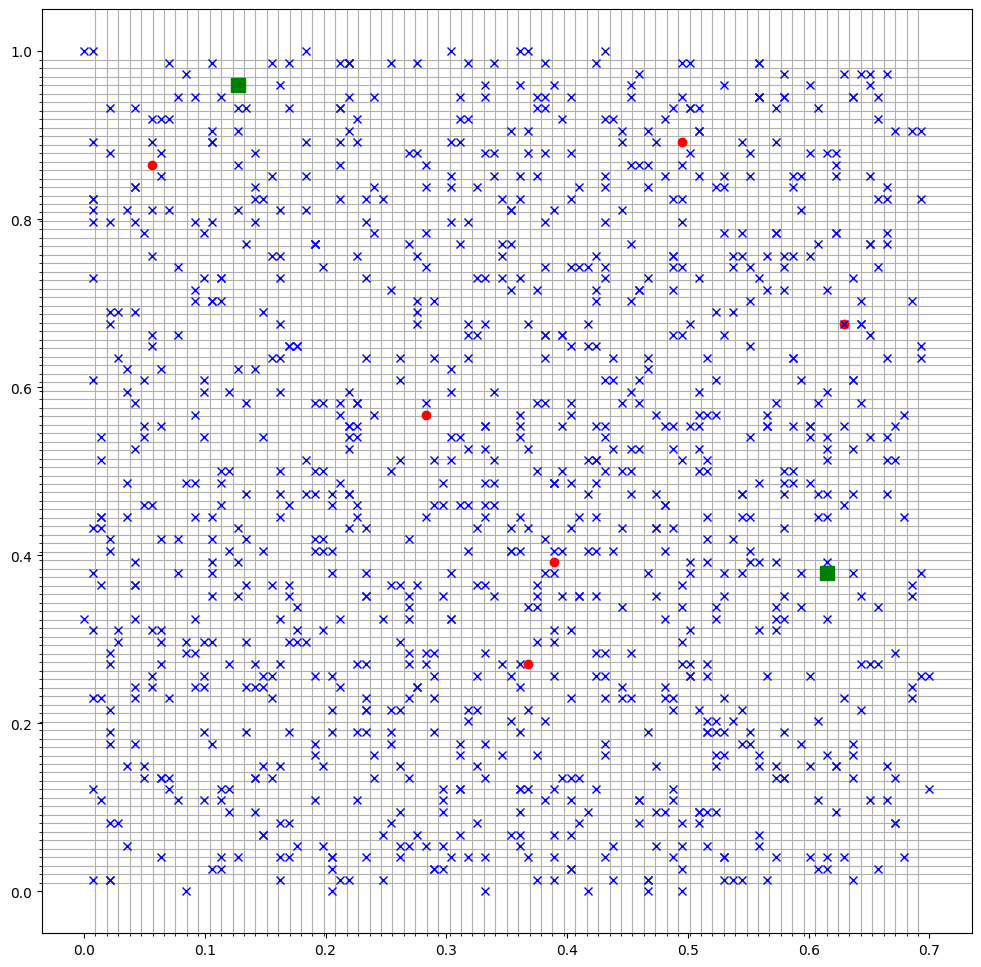

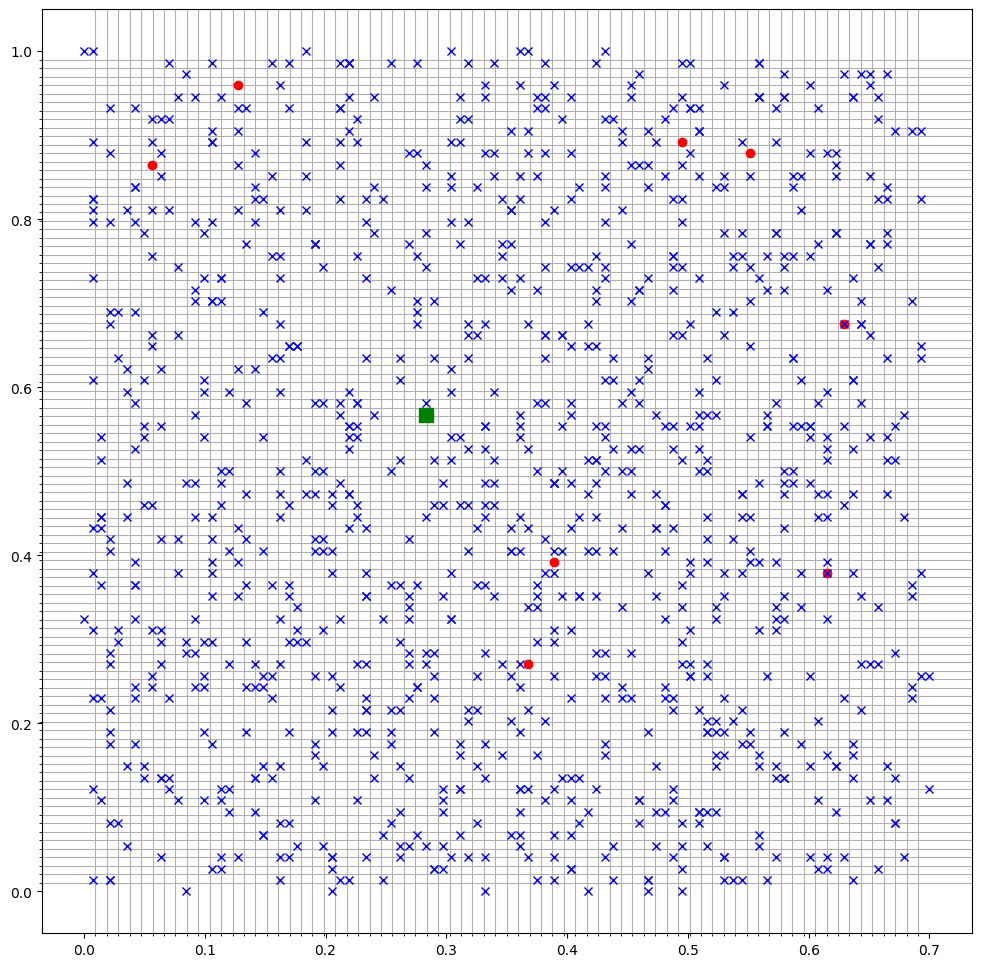

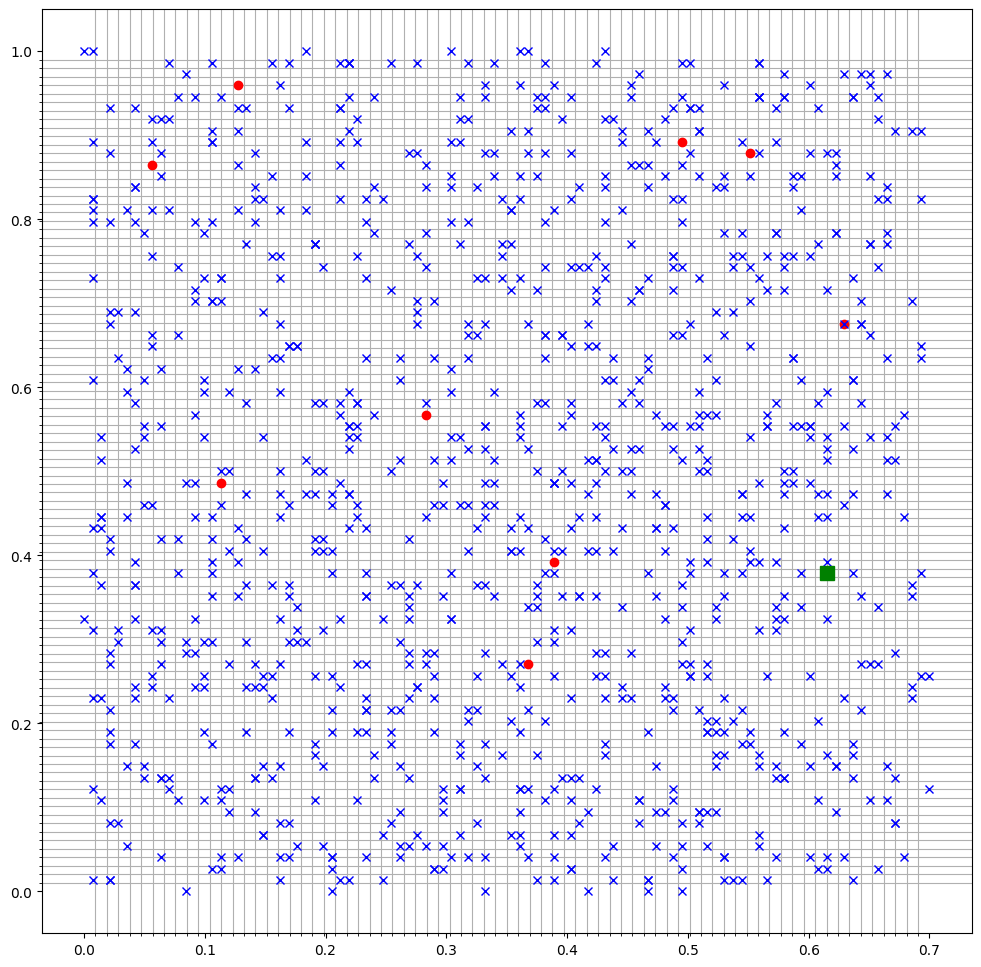

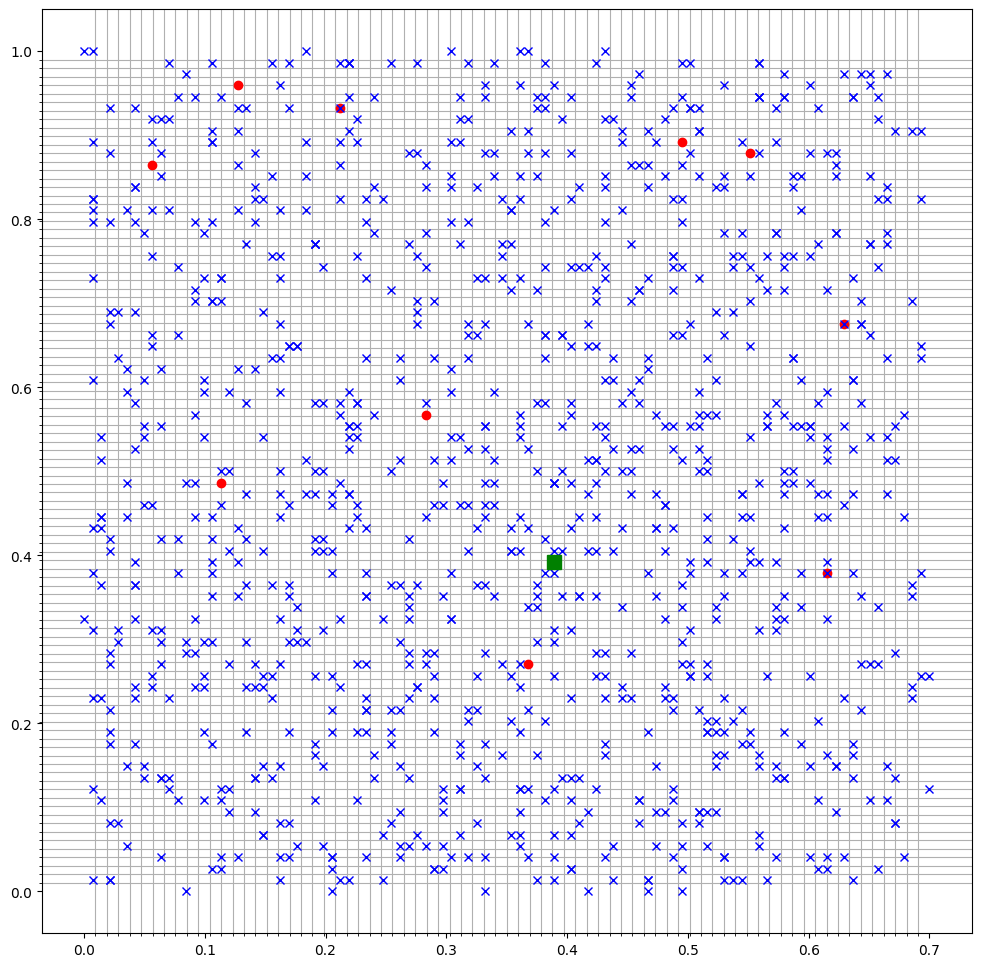

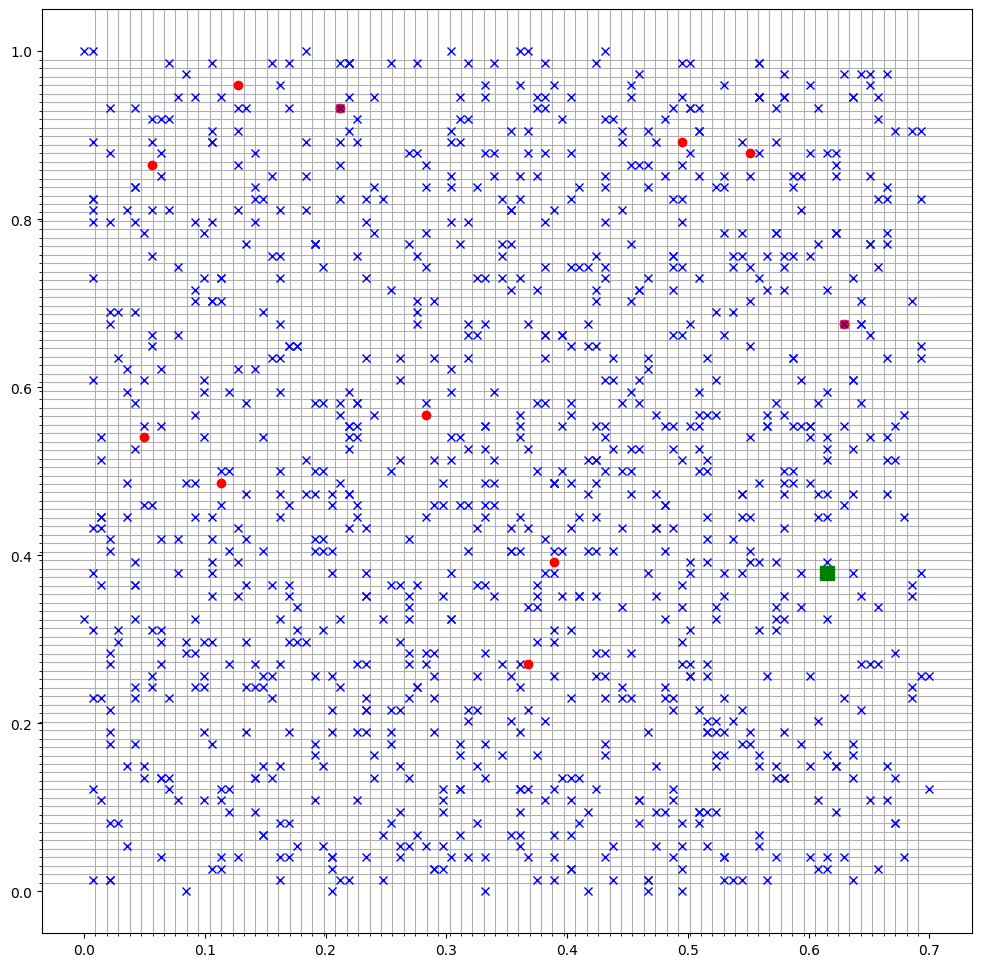

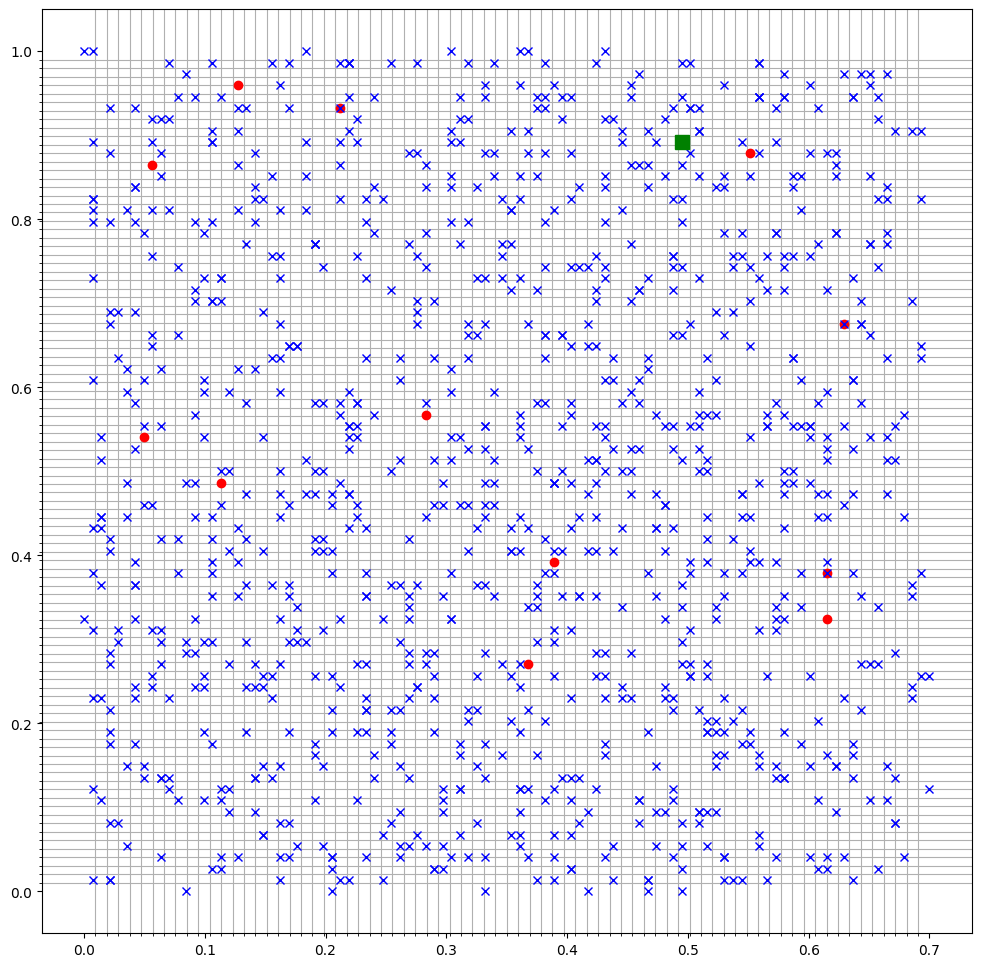

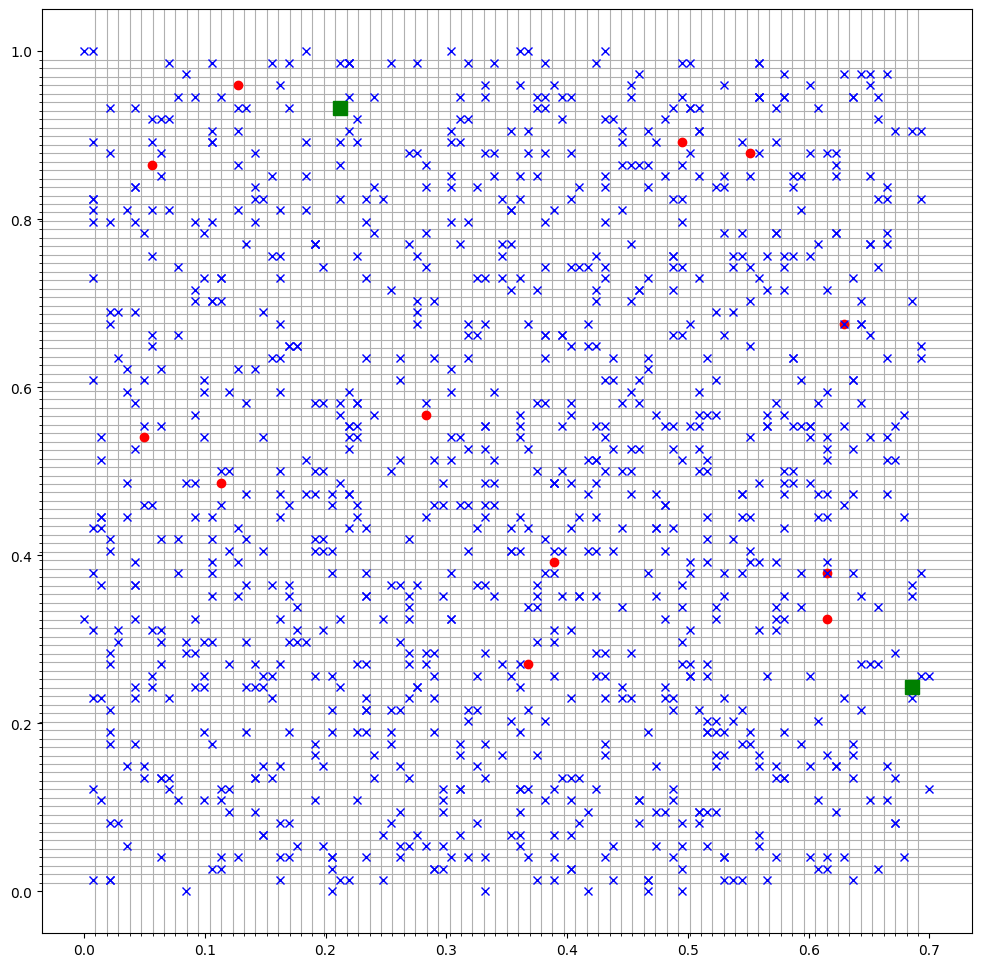

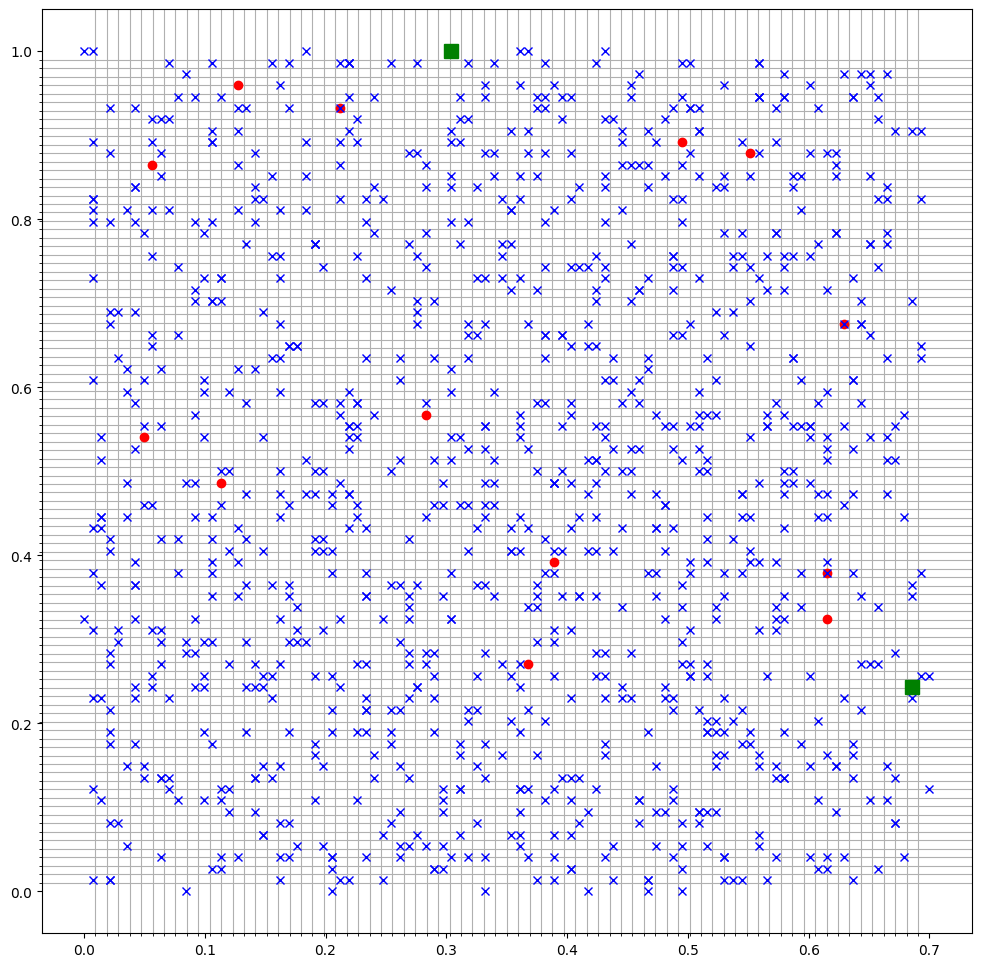

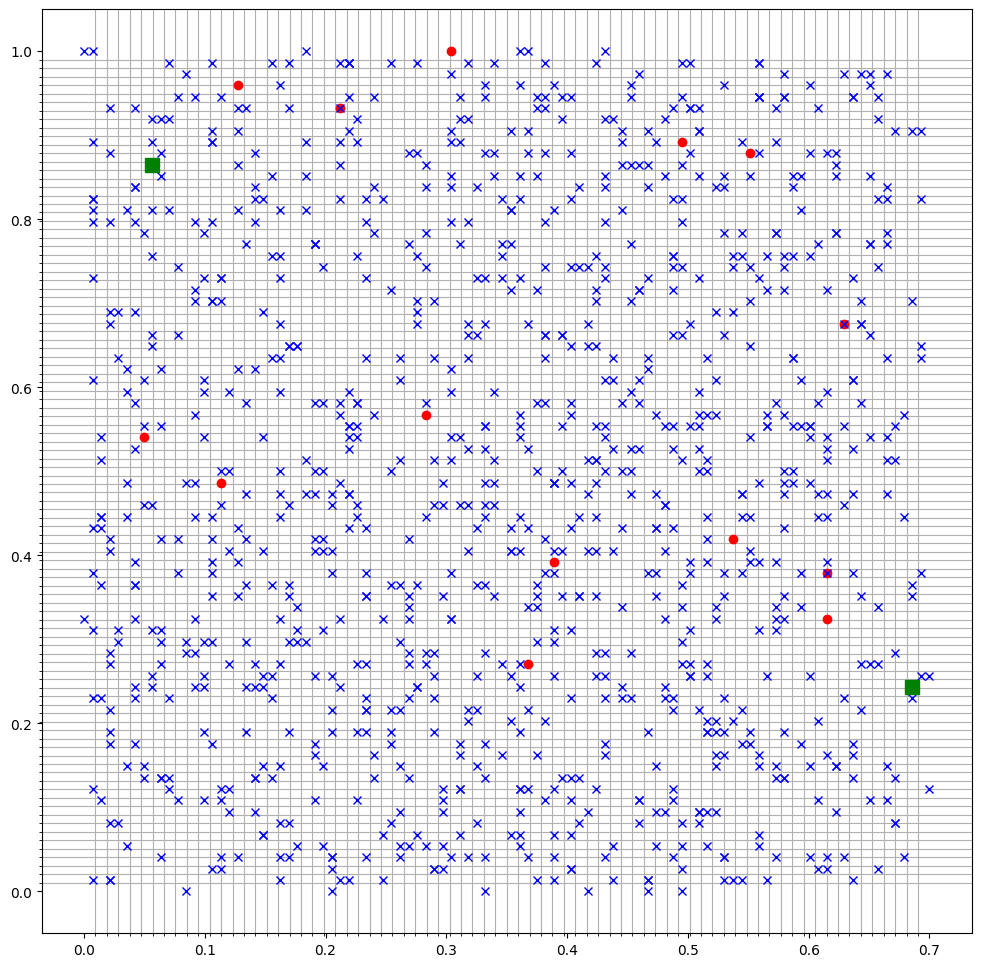

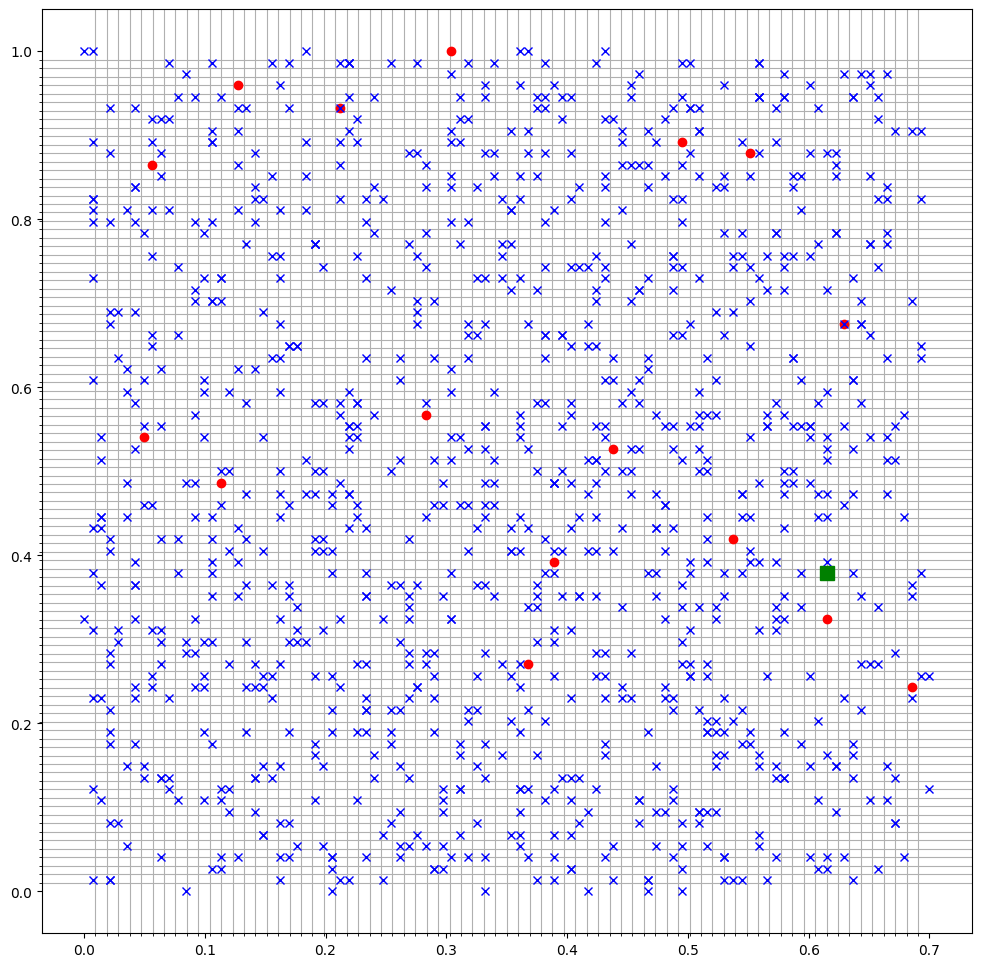

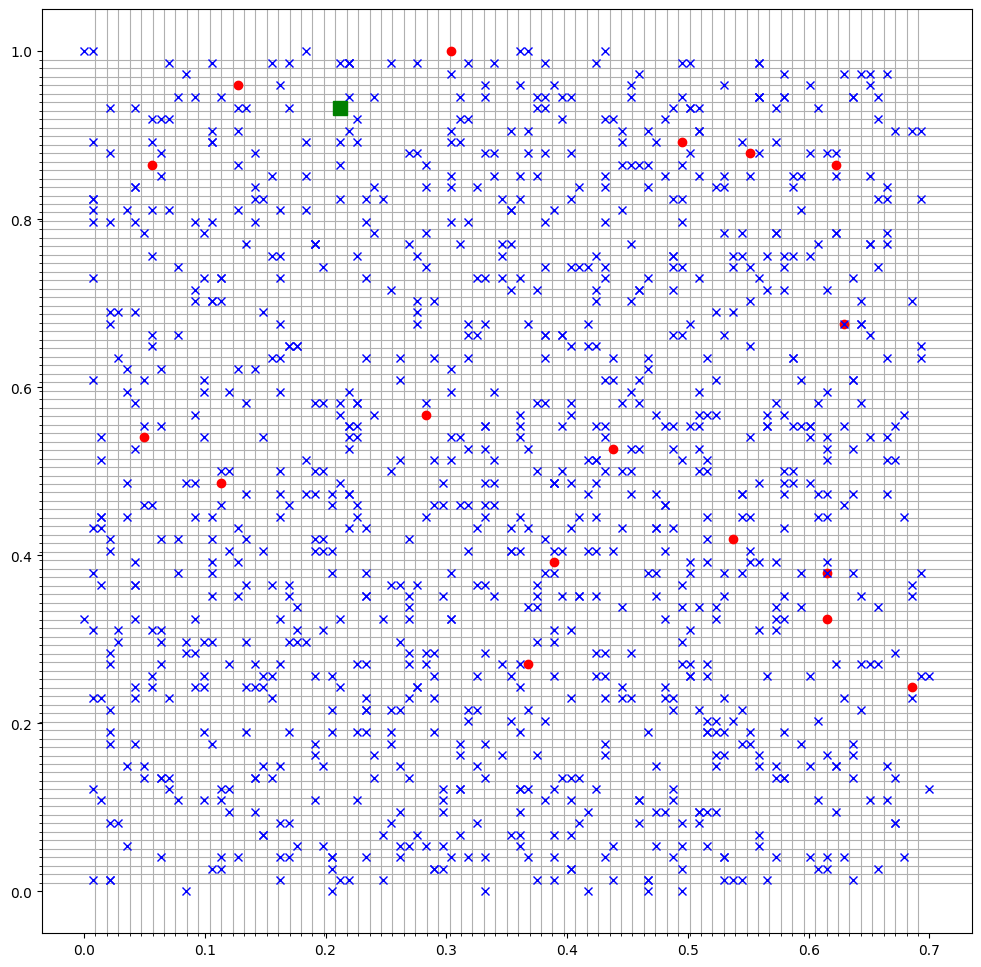

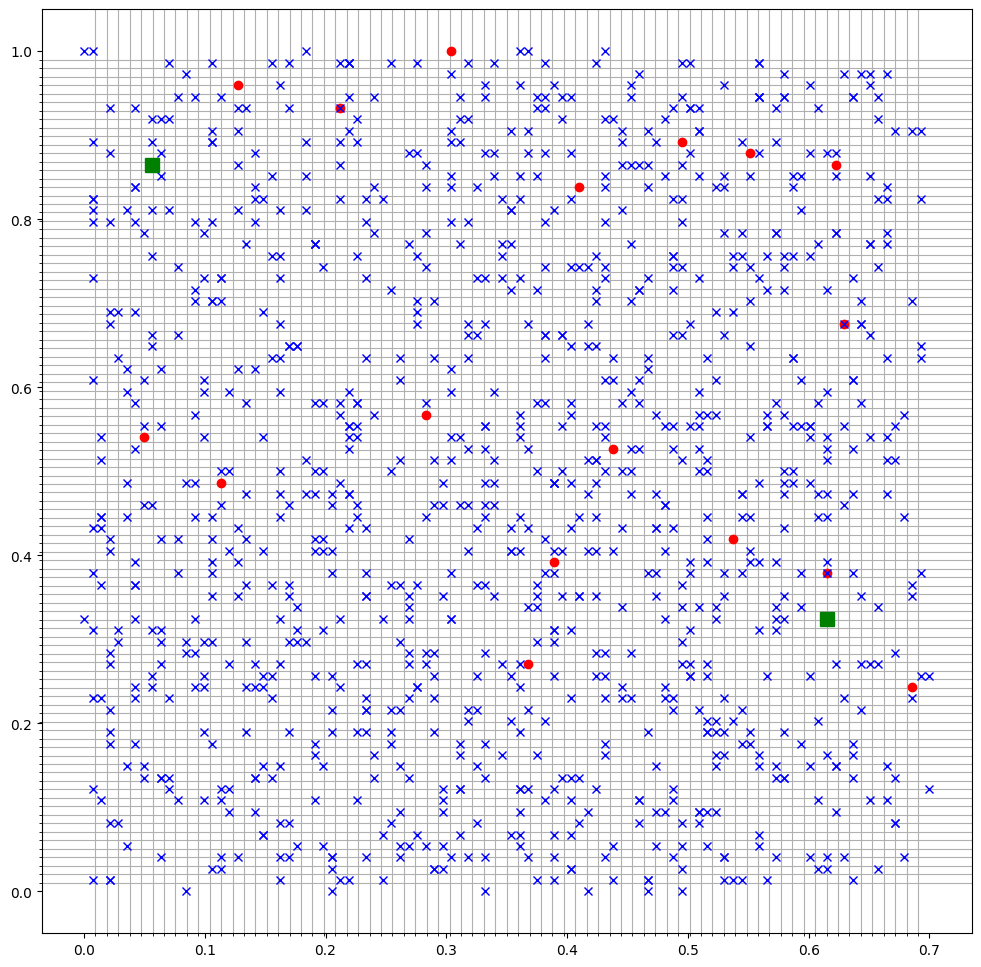

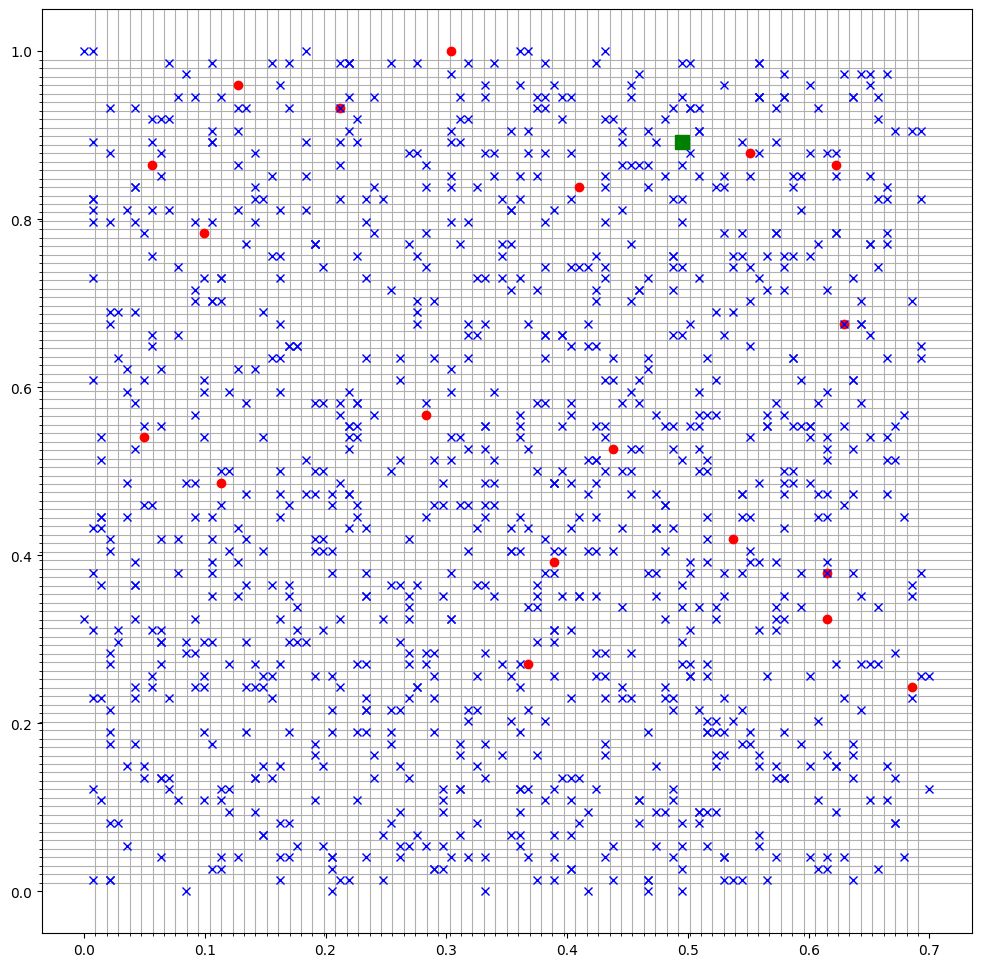

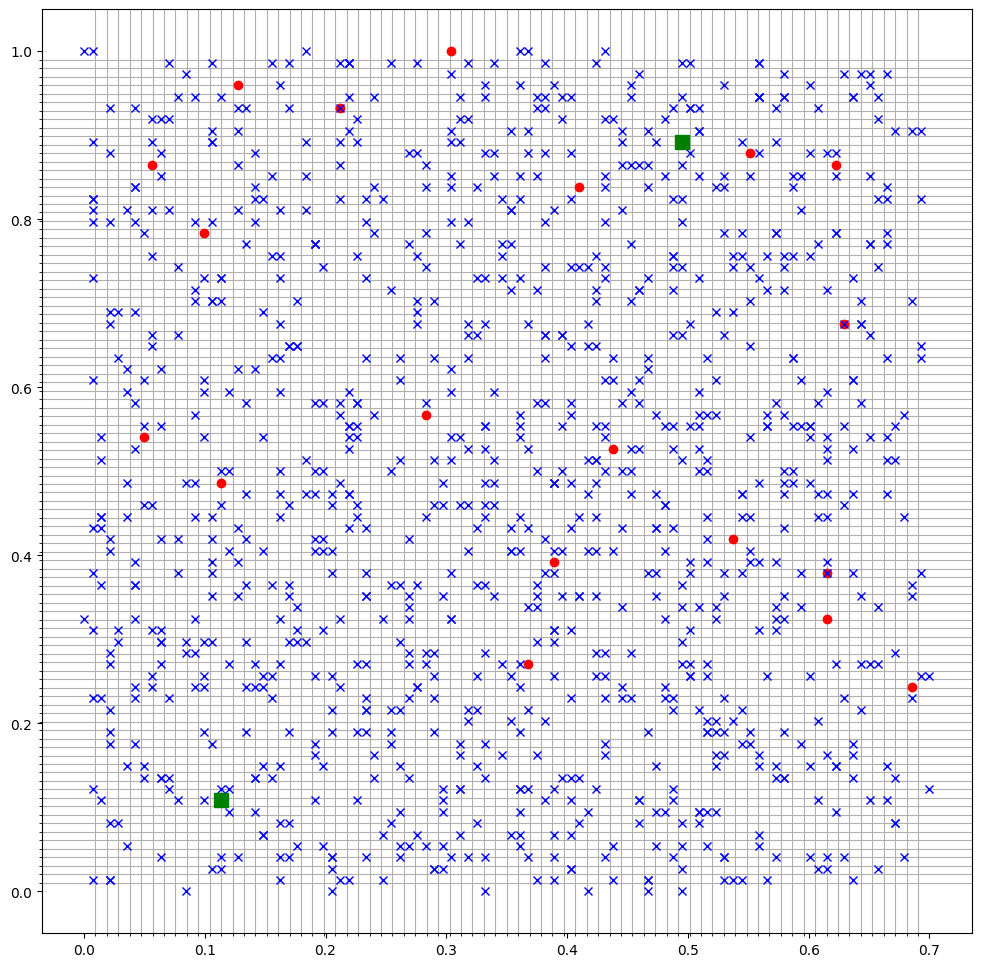

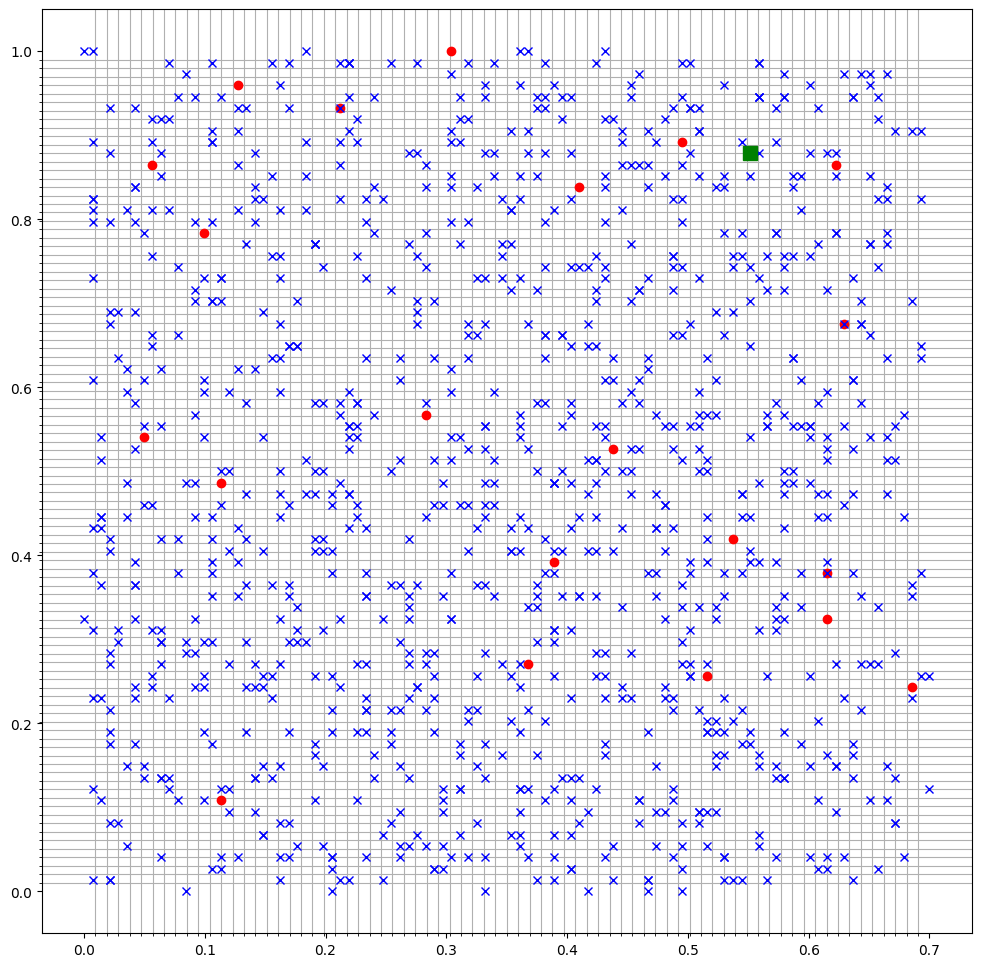

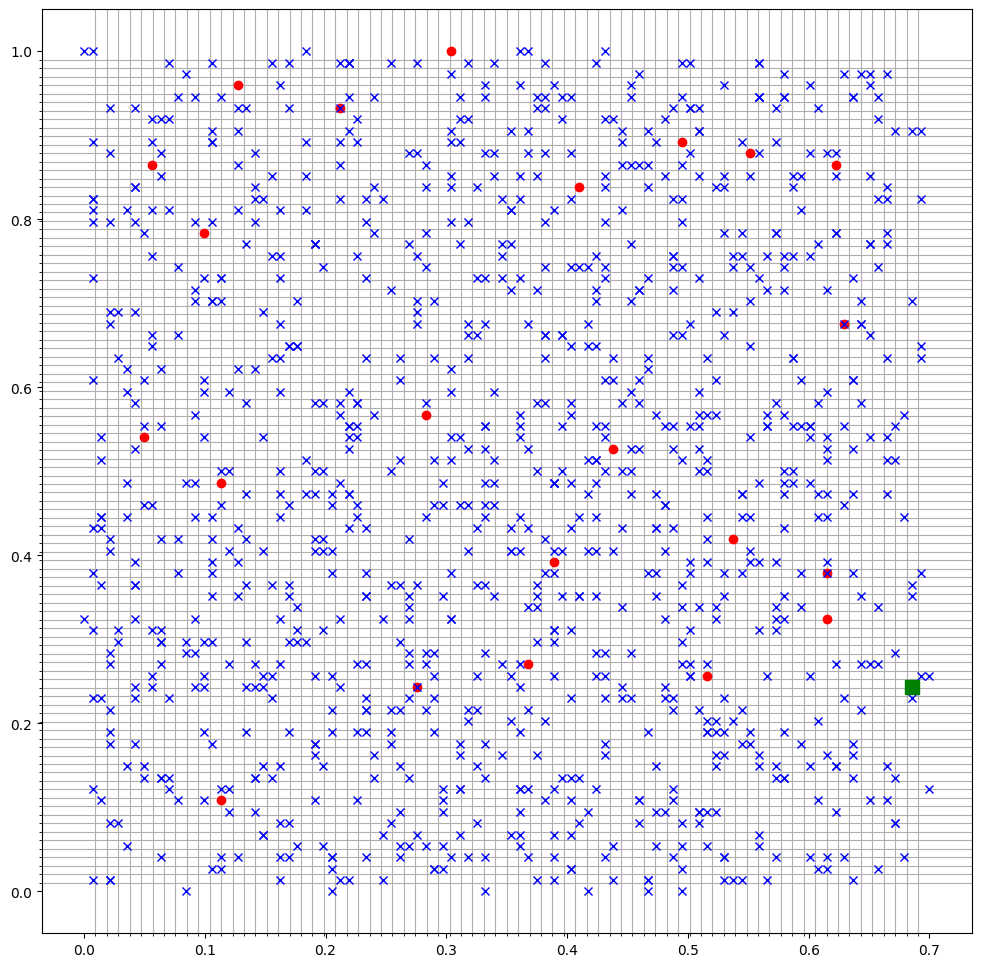

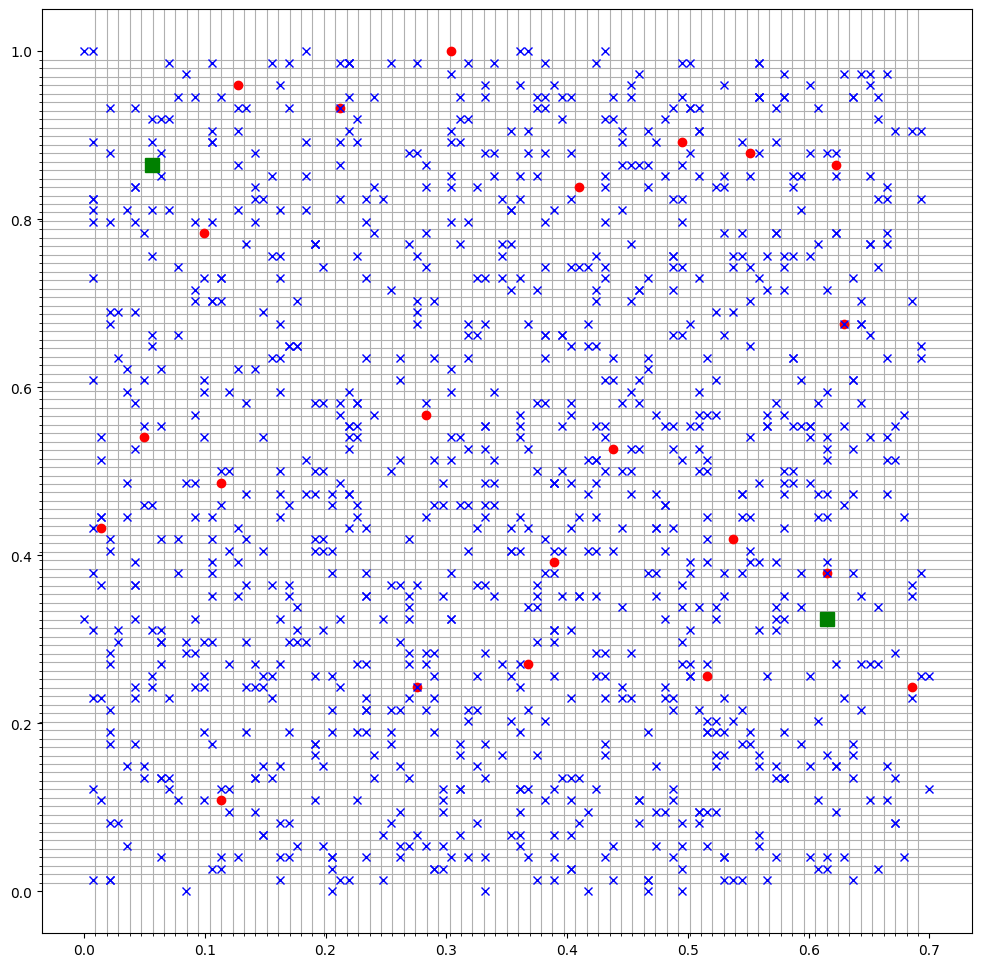

[2.9356606006622314, 3.5327887535095215, 3.844154119491577, 3.4014732837677, 3.055961847305298, 2.942469358444214, 2.890880823135376, 2.981642961502075, 3.994493246078491, 2.767064094543457, 2.5582752227783203, 2.840632677078247, 2.33516788482666, 2.6581480503082275, 3.0847859382629395, 2.715357780456543, 2.5940310955047607, 2.695997953414917, 2.4741036891937256, 2.806558132171631, 3.148548126220703, 2.76623797416687, 2.3987579345703125, 3.4573469161987305]


In [4]:
import time

durations = []
for i in range(1,25):
    t0 = time.time()
    a = FacilityLocation(i,1000,0.20,0.7,'SimulatedAnnealing',1,5)
    t1 = time.time()
    durations.append((t1-t0))

print(durations)

Please mind : 1 coressponds to 17 k, the distance will be shown in km 

In [5]:
atms_lon = 17*atms_lon
atms_lat = 17*atms_lat
clients_lon = 17*clients_lon
clients_lat = 17*clients_lat

In [6]:
def EuclideanDistance(x,y): 
    
    return np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

def assign_nearest(x_customer, y_customer, x_atm, y_atm):
    data_customer = []
    data_atm = []
    for i in range((x_customer.size)):
        data_customer.append([x_customer[i],y_customer[i]])
    for i in range(len(x_atm)):
        data_atm.append([x_atm[i],y_atm[i]])
    
    network = []
    length = []
    for customer in data_customer:
        allatms = []
        
        for atm in data_atm:
            allatms.append(EuclideanDistance((customer[0], customer[1]), (atm[0], atm[1])))
        nearest = np.argmin(allatms)
        length.append(np.min(allatms))
        network.append(nearest)
    return network, np.sum(length), length

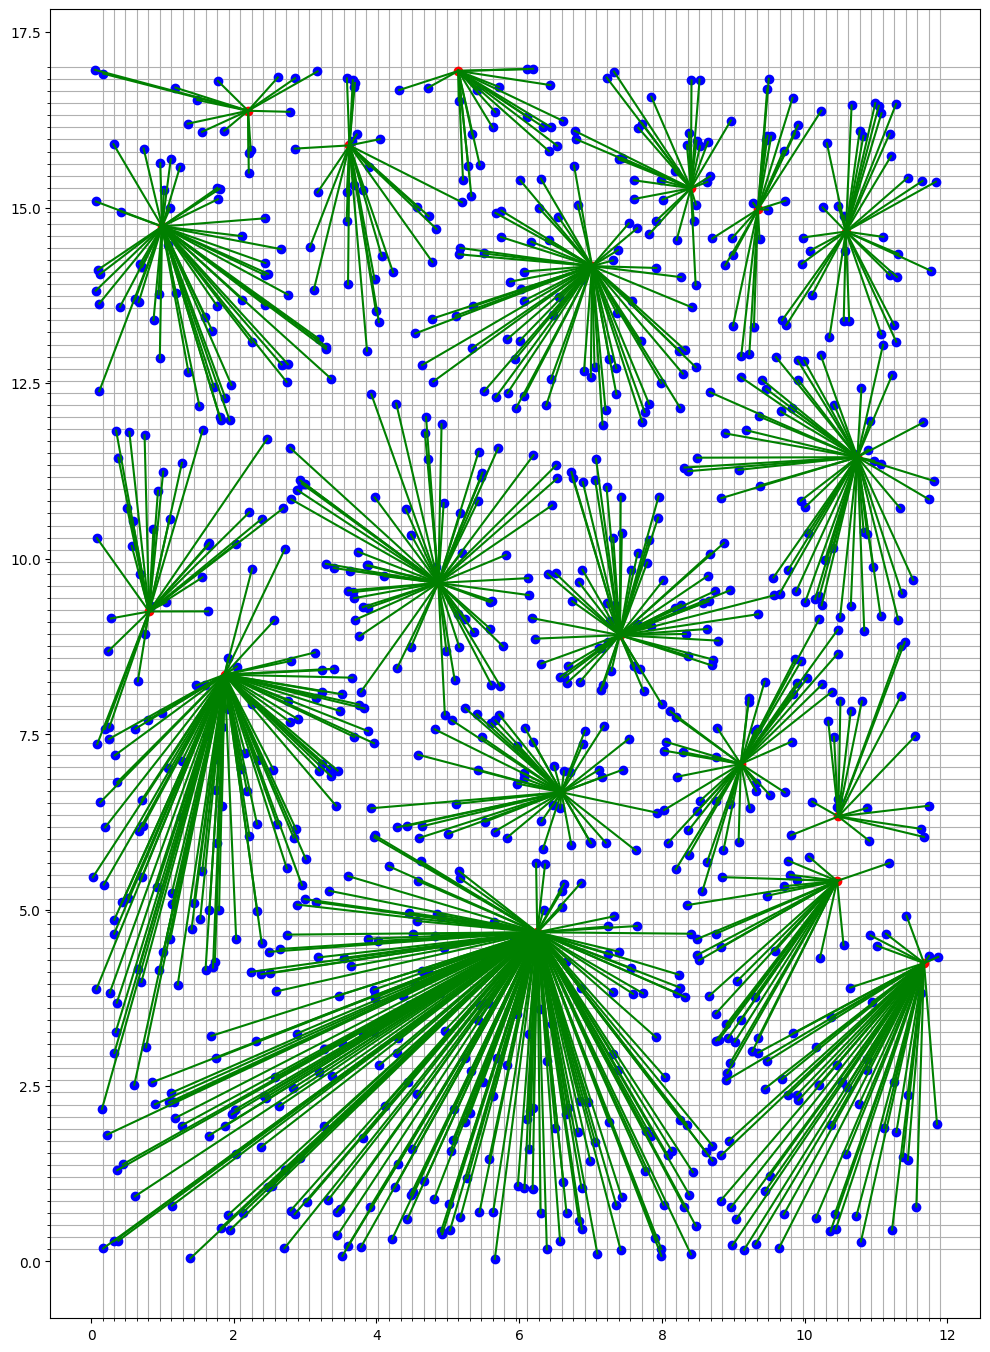

In [7]:
network, summ, length = assign_nearest(clients_lon, clients_lat, atms_lon, atms_lat)

%matplotlib inline

fig = plt.axes()
n_y = 20*5
n_x = 15*5
fig.figure.set_size_inches(12,17)
major_ticks_top=np.linspace(0,0.7*17,n_x)
fig.set_xticks (major_ticks_top, minor = True)
major_ticks_top=np.linspace(0, 1*17, n_y)
fig.set_yticks(major_ticks_top, minor = True)
fig.grid(which = 'minor')
fig.plot(atms_lon, atms_lat, 'ro')
fig.plot(clients_lon, clients_lat, 'bo')
for j in range(len(network)):
    fig.plot([clients_lon[j], atms_lon[network[j]]],[clients_lat[j],atms_lat[network[j]]], 'g')


In [11]:
np.sum(profits)
def quitting_clients(profits, lengths):   #assume that every second client whose distance is >2km will quit the bank,
                                        #this is approximately how much they will lose
    lost_profit = 0
    for i in range(profits.size):
        if lengths[i] > 2:
            lost_profit += profits[i]
    return lost_profit/2

In [12]:
lost_profit = quitting_clients(profits, length)
print('total possible profit (euro): ', np.sum(profits))
print('lost profit in this solution (in euro):', lost_profit)
print('realized profit (in euro):', np.sum(profits)-lost_profit)
print('Average distance (in km):', summ/len(clients_lon))

total possible profit (euro):  10233249.989325121
lost profit in this solution (in euro): 2044713.173379643
realized profit (in euro): 8188536.815945478
Average distance (in km): 2.0104866854914993


In [13]:
def metric(profits, lengths):
    return np.sum(profits*lengths)
metric = metric(profits, length)
metric

20662494.173822097